In [72]:
!pip install torch gymnasium[classic-control] numpy

In [73]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import os
BASE = "/content/drive/MyDrive/Cartpole_world_model"
os.makedirs(f"{BASE}/data", exist_ok=True)
os.makedirs(f"{BASE}/models", exist_ok=True)
os.makedirs(f"{BASE}/plots",  exist_ok=True)
os.makedirs(f"{BASE}/src",    exist_ok=True)
print("Project at:", BASE)

Project at: /content/drive/MyDrive/Cartpole_world_model


In [75]:
%%writefile src/collect.py
import gymnasium as gym
import numpy as np

out_path = "/content/drive/MyDrive/Cartpole_world_model/data/cartpole_data.npz"

def collect(episodes: int, out_path: str, seed: int = 0, render: bool = False):
    env = gym.make('CartPole-v1', render_mode='rgb_array' if render else None)
    env.action_space.seed(seed)
    env.reset(seed=seed)

    states, actions, next_states, rewards, dones = [], [], [], [], []

    for ep in range(episodes):
        print(f"Episode {ep+1}/{episodes}")
        s, _ = env.reset()
        done = False
        while not done:
            a = env.action_space.sample()
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            states.append(s.astype(np.float32))
            actions.append(int(a))
            next_states.append(s2.astype(np.float32))
            rewards.append(np.float32(r))
            dones.append(bool(done))

            s = s2

    states = np.asarray(states, dtype=np.float32)
    actions = np.asarray(actions, dtype=np.int64)
    next_states = np.asarray(next_states, dtype=np.float32)
    rewards = np.asarray(rewards, dtype=np.float32)
    dones = np.asarray(dones, dtype=bool)

    np.savez_compressed(out_path, states=states, actions=actions,
                        next_states=next_states, rewards=rewards, dones=dones)
    print(f"Saved dataset with {states.shape[0]} samples to {out_path}")

if __name__ == "__main__":
    collect(episodes=100, out_path=out_path)

Overwriting src/collect.py


In [76]:
%%writefile /content/drive/MyDrive/Cartpole_world_model/src/collect.py

Overwriting /content/drive/MyDrive/Cartpole_world_model/src/collect.py


In [77]:
%%writefile /content/drive/MyDrive/Cartpole_world_model/src/train_bc.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

data_path = "/content/drive/MyDrive/Cartpole_world_model/data/cartpole_data.npz"
model_path = "/content/drive/MyDrive/Cartpole_world_model/models/policy_net.pt"


data = np.load(data_path)
states = torch.tensor(data["states"], dtype=torch.float32)
actions = torch.tensor(data["actions"], dtype=torch.long)


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)


model = PolicyNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(states)
    loss = criterion(outputs, actions)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Overwriting /content/drive/MyDrive/Cartpole_world_model/src/train_bc.py


In [78]:
!python /content/drive/MyDrive/Cartpole_world_model/src/train_bc.py


Epoch 1/20, Loss: 0.6954
Epoch 2/20, Loss: 0.6946
Epoch 3/20, Loss: 0.6940
Epoch 4/20, Loss: 0.6935
Epoch 5/20, Loss: 0.6930
Epoch 6/20, Loss: 0.6927
Epoch 7/20, Loss: 0.6924
Epoch 8/20, Loss: 0.6922
Epoch 9/20, Loss: 0.6921
Epoch 10/20, Loss: 0.6921
Epoch 11/20, Loss: 0.6920
Epoch 12/20, Loss: 0.6920
Epoch 13/20, Loss: 0.6920
Epoch 14/20, Loss: 0.6920
Epoch 15/20, Loss: 0.6920
Epoch 16/20, Loss: 0.6920
Epoch 17/20, Loss: 0.6920
Epoch 18/20, Loss: 0.6919
Epoch 19/20, Loss: 0.6919
Epoch 20/20, Loss: 0.6918
Model saved to /content/drive/MyDrive/Cartpole_world_model/models/policy_net.pt


In [79]:
%%writefile /content/drive/MyDrive/Cartpole_world_model/src/train_bc.py

import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np

class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

  def forward(self, x):
    return self.net(x)


model = PolicyNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Cartpole_world_model/models/policy_net.pt'))
model.eval()

env = gym.make('CartPole-v1', render_mode='human')

for episode in range(5):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action = model(state_t).argmax(dim=1).item()
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
    print(f"Episode {episode+1}: Total Reward = {total_reward}")

env.close()

Overwriting /content/drive/MyDrive/Cartpole_world_model/src/train_bc.py


In [80]:
%%writefile /content/drive/MyDrive/Cartpole_world_model/src/eval.py


Overwriting /content/drive/MyDrive/Cartpole_world_model/src/eval.py


Episode 1/200, Reward: 9.0
Episode 2/200, Reward: 9.0
Episode 3/200, Reward: 9.0
Episode 4/200, Reward: 10.0
Episode 5/200, Reward: 10.0
Episode 6/200, Reward: 9.0
Episode 7/200, Reward: 10.0
Episode 8/200, Reward: 9.0
Episode 9/200, Reward: 11.0
Episode 10/200, Reward: 9.0
Episode 11/200, Reward: 9.0
Episode 12/200, Reward: 11.0
Episode 13/200, Reward: 12.0
Episode 14/200, Reward: 9.0
Episode 15/200, Reward: 8.0


/tmp/ipython-input-4174434418.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 16/200, Reward: 10.0
Episode 17/200, Reward: 9.0
Episode 18/200, Reward: 12.0
Episode 19/200, Reward: 10.0
Episode 20/200, Reward: 10.0
Episode 21/200, Reward: 12.0
Episode 22/200, Reward: 12.0
Episode 23/200, Reward: 10.0
Episode 24/200, Reward: 10.0
Episode 25/200, Reward: 9.0
Episode 26/200, Reward: 9.0
Episode 27/200, Reward: 8.0
Episode 28/200, Reward: 11.0
Episode 29/200, Reward: 10.0
Episode 30/200, Reward: 10.0
Episode 31/200, Reward: 11.0
Episode 32/200, Reward: 10.0
Episode 33/200, Reward: 15.0
Episode 34/200, Reward: 13.0
Episode 35/200, Reward: 9.0
Episode 36/200, Reward: 9.0
Episode 37/200, Reward: 12.0
Episode 38/200, Reward: 10.0
Episode 39/200, Reward: 13.0
Episode 40/200, Reward: 11.0
Episode 41/200, Reward: 11.0
Episode 42/200, Reward: 12.0
Episode 43/200, Reward: 12.0
Episode 44/200, Reward: 10.0
Episode 45/200, Reward: 12.0
Episode 46/200, Reward: 18.0
Episode 47/200, Reward: 16.0
Episode 48/200, Reward: 12.0
Episode 49/200, Reward: 18.0
Episode 50/200, Rewa

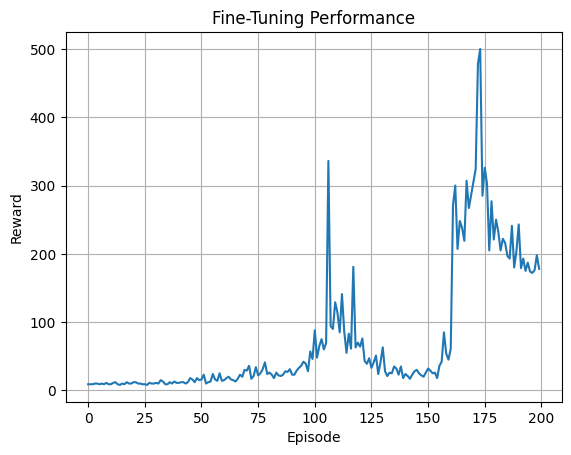

In [81]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os

model_path = "/content/drive/MyDrive/Cartpole_world_model/models/policy_net.pt"
finetuned_model_path = "/content/drive/MyDrive/Cartpole_world_model/models/policy_net_finetuned.pt"


replay_buffer = deque(maxlen=5000)

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)


model = PolicyNet()
model.load_state_dict(torch.load(model_path))
target_model = PolicyNet()
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=1e-3)

GAMMA = 0.99
BATCH_SIZE = 64
EPSILON = 0.1
EPISODES = 200

def select_action(state):
    if random.random() < EPSILON:
        return random.randint(0, 1)
    with torch.no_grad():
        return model(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax(dim=1).item()

def optimize():
    if len(replay_buffer) < BATCH_SIZE:
        return
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = model(states).gather(1, actions)
    next_q_values = target_model(next_states).max(1)[0].unsqueeze(1).detach()
    target = rewards + GAMMA * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env = gym.make('CartPole-v1')
reward_history = []

for ep in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        optimize()
    reward_history.append(total_reward)


    if ep % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    print(f"Episode {ep+1}/{EPISODES}, Reward: {total_reward}")

env.close()


os.makedirs(os.path.dirname(finetuned_model_path), exist_ok=True)
torch.save(model.state_dict(), finetuned_model_path)
print(f"Fine-tuned model saved to {finetuned_model_path}")


plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Fine-Tuning Performance")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Cartpole_world_model/plots/fine_tuning_rewards.png")
plt.show()

In [82]:
%%writefile /content/drive/MyDrive/Cartpole_world_model/src/fine_tune.py
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from collections import deque

base = "/content/drive/MyDrive/Cartpole_world_model"
pretrained = f"{base}/models/policy_net.pt"
finetuned = f"{base}/models/policy_net_finetuned.pt"
plot_path = f"{base}/plots/fine_tuning_rewards.png"


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)


model = PolicyNet()
model.load_state_dict(torch.load(pretrained))
target = PolicyNet()
target.load_state_dict(model.state_dict())
target.eval()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


GAMMA = 0.99
BATCH = 64
EPISODES = 150
EPSILON = 0.1
TARGET_UPDATE = 10
REPLAY_CAP = 5000

replay = deque(maxlen=REPLAY_CAP)
env = gym.make("CartPole-v1")
reward_hist = []

def select_action(state):
    if random.random() < EPSILON:
        return random.randrange(2)
    with torch.no_grad():
        q = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        return int(q.argmax(dim=1).item())

def optimize():
    if len(replay) < BATCH:
        return
    batch = random.sample(replay, BATCH)
    s, a, r, s2, d = zip(*batch)

    s  = torch.tensor(s,  dtype=torch.float32)
    a  = torch.tensor(a,  dtype=torch.int64).unsqueeze(1)
    r  = torch.tensor(r,  dtype=torch.float32).unsqueeze(1)
    s2 = torch.tensor(s2, dtype=torch.float32)
    d  = torch.tensor(d,  dtype=torch.float32).unsqueeze(1)

    q_sa = model(s).gather(1, a)
    with torch.no_grad():
        q_next = target(s2).max(1, keepdim=True)[0]
        y = r + GAMMA * q_next * (1 - d)

    loss = nn.MSELoss()(q_sa, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for ep in range(1, EPISODES+1):
    state, _ = env.reset()
    done = False
    total = 0.0
    while not done:
        action = select_action(state)
        ns, r, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay.append((state, action, r, ns, done))
        state = ns
        total += r
        optimize()

    if ep % TARGET_UPDATE == 0:
        target.load_state_dict(model.state_dict())

    reward_hist.append(total)
    print(f"Episode {ep}/{EPISODES} | Reward: {total}")

env.close()


os.makedirs(f"{base}/models", exist_ok=True)
torch.save(model.state_dict(), finetuned)
print(f"Saved fine-tuned model to: {finetuned}")


os.makedirs(f"{base}/plots", exist_ok=True)
plt.figure()
plt.plot(reward_hist)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Fine-tuning reward over episodes")
plt.grid(True)
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Saved plot to: {plot_path}")




Overwriting /content/drive/MyDrive/Cartpole_world_model/src/fine_tune.py


In [83]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np

base = "/content/drive/MyDrive/Cartpole_world_model"
before_path = f"{base}/models/policy_net.pt"
after_path  = f"{base}/models/policy_net_finetuned.pt"

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

def avg_reward(model_path, episodes=20):
    model = PolicyNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    env = gym.make("CartPole-v1")
    totals = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0.0
        while not done:
            with torch.no_grad():
                a = model(torch.tensor(s, dtype=torch.float32).unsqueeze(0)).argmax(1).item()
            s, r, term, trunc, _ = env.step(a)
            total += r
            done = term or trunc
        totals.append(total)
    env.close()
    return float(np.mean(totals)), float(np.std(totals))

before_mean, before_std = avg_reward(before_path, episodes=20)
after_mean,  after_std  = avg_reward(after_path,  episodes=20)

print(f"Before (imitation):   avg={before_mean:.1f} ± {before_std:.1f}")
print(f"After  (fine-tuned):  avg={after_mean:.1f} ± {after_std:.1f}")

Before (imitation):   avg=9.2 ± 0.7
After  (fine-tuned):  avg=196.8 ± 12.2
